# **Process pseudobulks for subtype prediction**


You will run this 3 times, one for cellType, granular, and subtype pseudobulks
You can edit this in the parameters res_name and celltype_name


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-07 20:13:24.526094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 20:13:24.526492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 20:13:24.528504: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 20:13:24.534136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736306004.543399 2366252 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736306004.54

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE154600_pseudobulks/"


exp_id = "all-granular" # cellType subtype granular

if exp_id == "all-cellType":
    res_id = "cellType" 
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all_subtype":
    res_id = "subtype"


curr_treatment = "drug"
result_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [3]:
# now get the sc ref training data

# read in order
# oritinal samples
sample_order = ['Samp_T59', 'Samp_T76', 'Samp_T77', 'Samp_T89', 'Samp_T90']



X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, _, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



Samp_T59
Samp_T76
Samp_T77
Samp_T89
Samp_T90


In [4]:
gene_df

gene_ids
AL627309.1    AL627309.1
AL669831.5    AL669831.5
FAM87B            FAM87B
LINC00115      LINC00115
FAM41C            FAM41C
                 ...    
AC023491.2    AC023491.2
AC004556.1    AC004556.1
AC233755.2    AC233755.2
AC233755.1    AC233755.1
AC240274.1    AC240274.1
Name: gene_ids, Length: 24520, dtype: object

In [5]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_T59,CTRL,Train,random,sc_ref
1,Samp_T59,CTRL,Train,random,sc_ref
2,Samp_T59,CTRL,Train,random,sc_ref
3,Samp_T59,CTRL,Train,random,sc_ref
4,Samp_T59,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1296,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1297,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1298,Samp_T90,CTRL,Train,cell_type_specific,sc_ref


In [6]:
X_concat

gene_ids,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,AL645608.5,AL645608.1,SAMD11,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1
0,0.0,2.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,15.0,...,0.0,3.0,1.0,8.0,0.0,0.0,9.0,0.0,0.0,2.0
0,0.0,5.0,0.0,3.0,2.0,0.0,0.0,0.0,2.0,12.0,...,0.0,1.0,0.0,9.0,2.0,0.0,5.0,1.0,0.0,2.0
0,1.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,16.0,...,0.0,5.0,3.0,19.0,1.0,1.0,5.0,0.0,0.0,3.0
0,0.0,9.0,0.0,9.0,11.0,0.0,3.0,0.0,3.0,29.0,...,1.0,7.0,4.0,20.0,1.0,0.0,8.0,0.0,0.0,2.0
0,0.0,5.0,2.0,4.0,2.0,0.0,1.0,0.0,0.0,13.0,...,0.0,2.0,5.0,15.0,0.0,0.0,7.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,6.0,2.0,4.0,0.0,0.0,0.0,2.0,1.0,28.0,...,4.0,8.0,11.0,6.0,5.0,0.0,0.0,0.0,0.0,6.0
0,0.0,2.0,1.0,4.0,7.0,0.0,0.0,1.0,1.0,30.0,...,2.0,10.0,8.0,9.0,4.0,0.0,0.0,0.0,0.0,7.0
0,0.0,4.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,21.0,...,1.0,7.0,7.0,5.0,4.0,0.0,0.0,0.0,0.0,12.0
0,0.0,5.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,30.0,...,1.0,7.0,7.0,4.0,3.0,0.0,0.0,0.0,1.0,14.0


In [7]:
# double check all the pseudobulks/bulks were read in
meta_concat.sample_id.value_counts()

Samp_T59    1300
Samp_T76    1300
Samp_T77    1300
Samp_T89    1300
Samp_T90    1300
Name: sample_id, dtype: int64

In [8]:
Y_concat

,immune,tumor,stromal
0,0.500000,0.425000,0.075000
0,0.260000,0.045000,0.695000
0,0.170000,0.425000,0.405000
0,0.025000,0.730000,0.245000
0,0.105000,0.085000,0.810000
...,...,...,...
0,0.006029,0.010921,0.983050
0,0.011116,0.013224,0.975659
0,0.005960,0.019983,0.974057
0,0.031106,0.016910,0.951984


# Plot all data

In [9]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_T59,CTRL,Train,random,sc_ref
1,Samp_T59,CTRL,Train,random,sc_ref
2,Samp_T59,CTRL,Train,random,sc_ref
3,Samp_T59,CTRL,Train,random,sc_ref
4,Samp_T59,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1296,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1297,Samp_T90,CTRL,Train,cell_type_specific,sc_ref
1298,Samp_T90,CTRL,Train,cell_type_specific,sc_ref


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.040s...
[t-SNE] Computed neighbors for 1000 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7785.471943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.564026
[t-SNE] KL divergence after 500 iterations: 0.415845
(1000, 2)
(1000, 2)


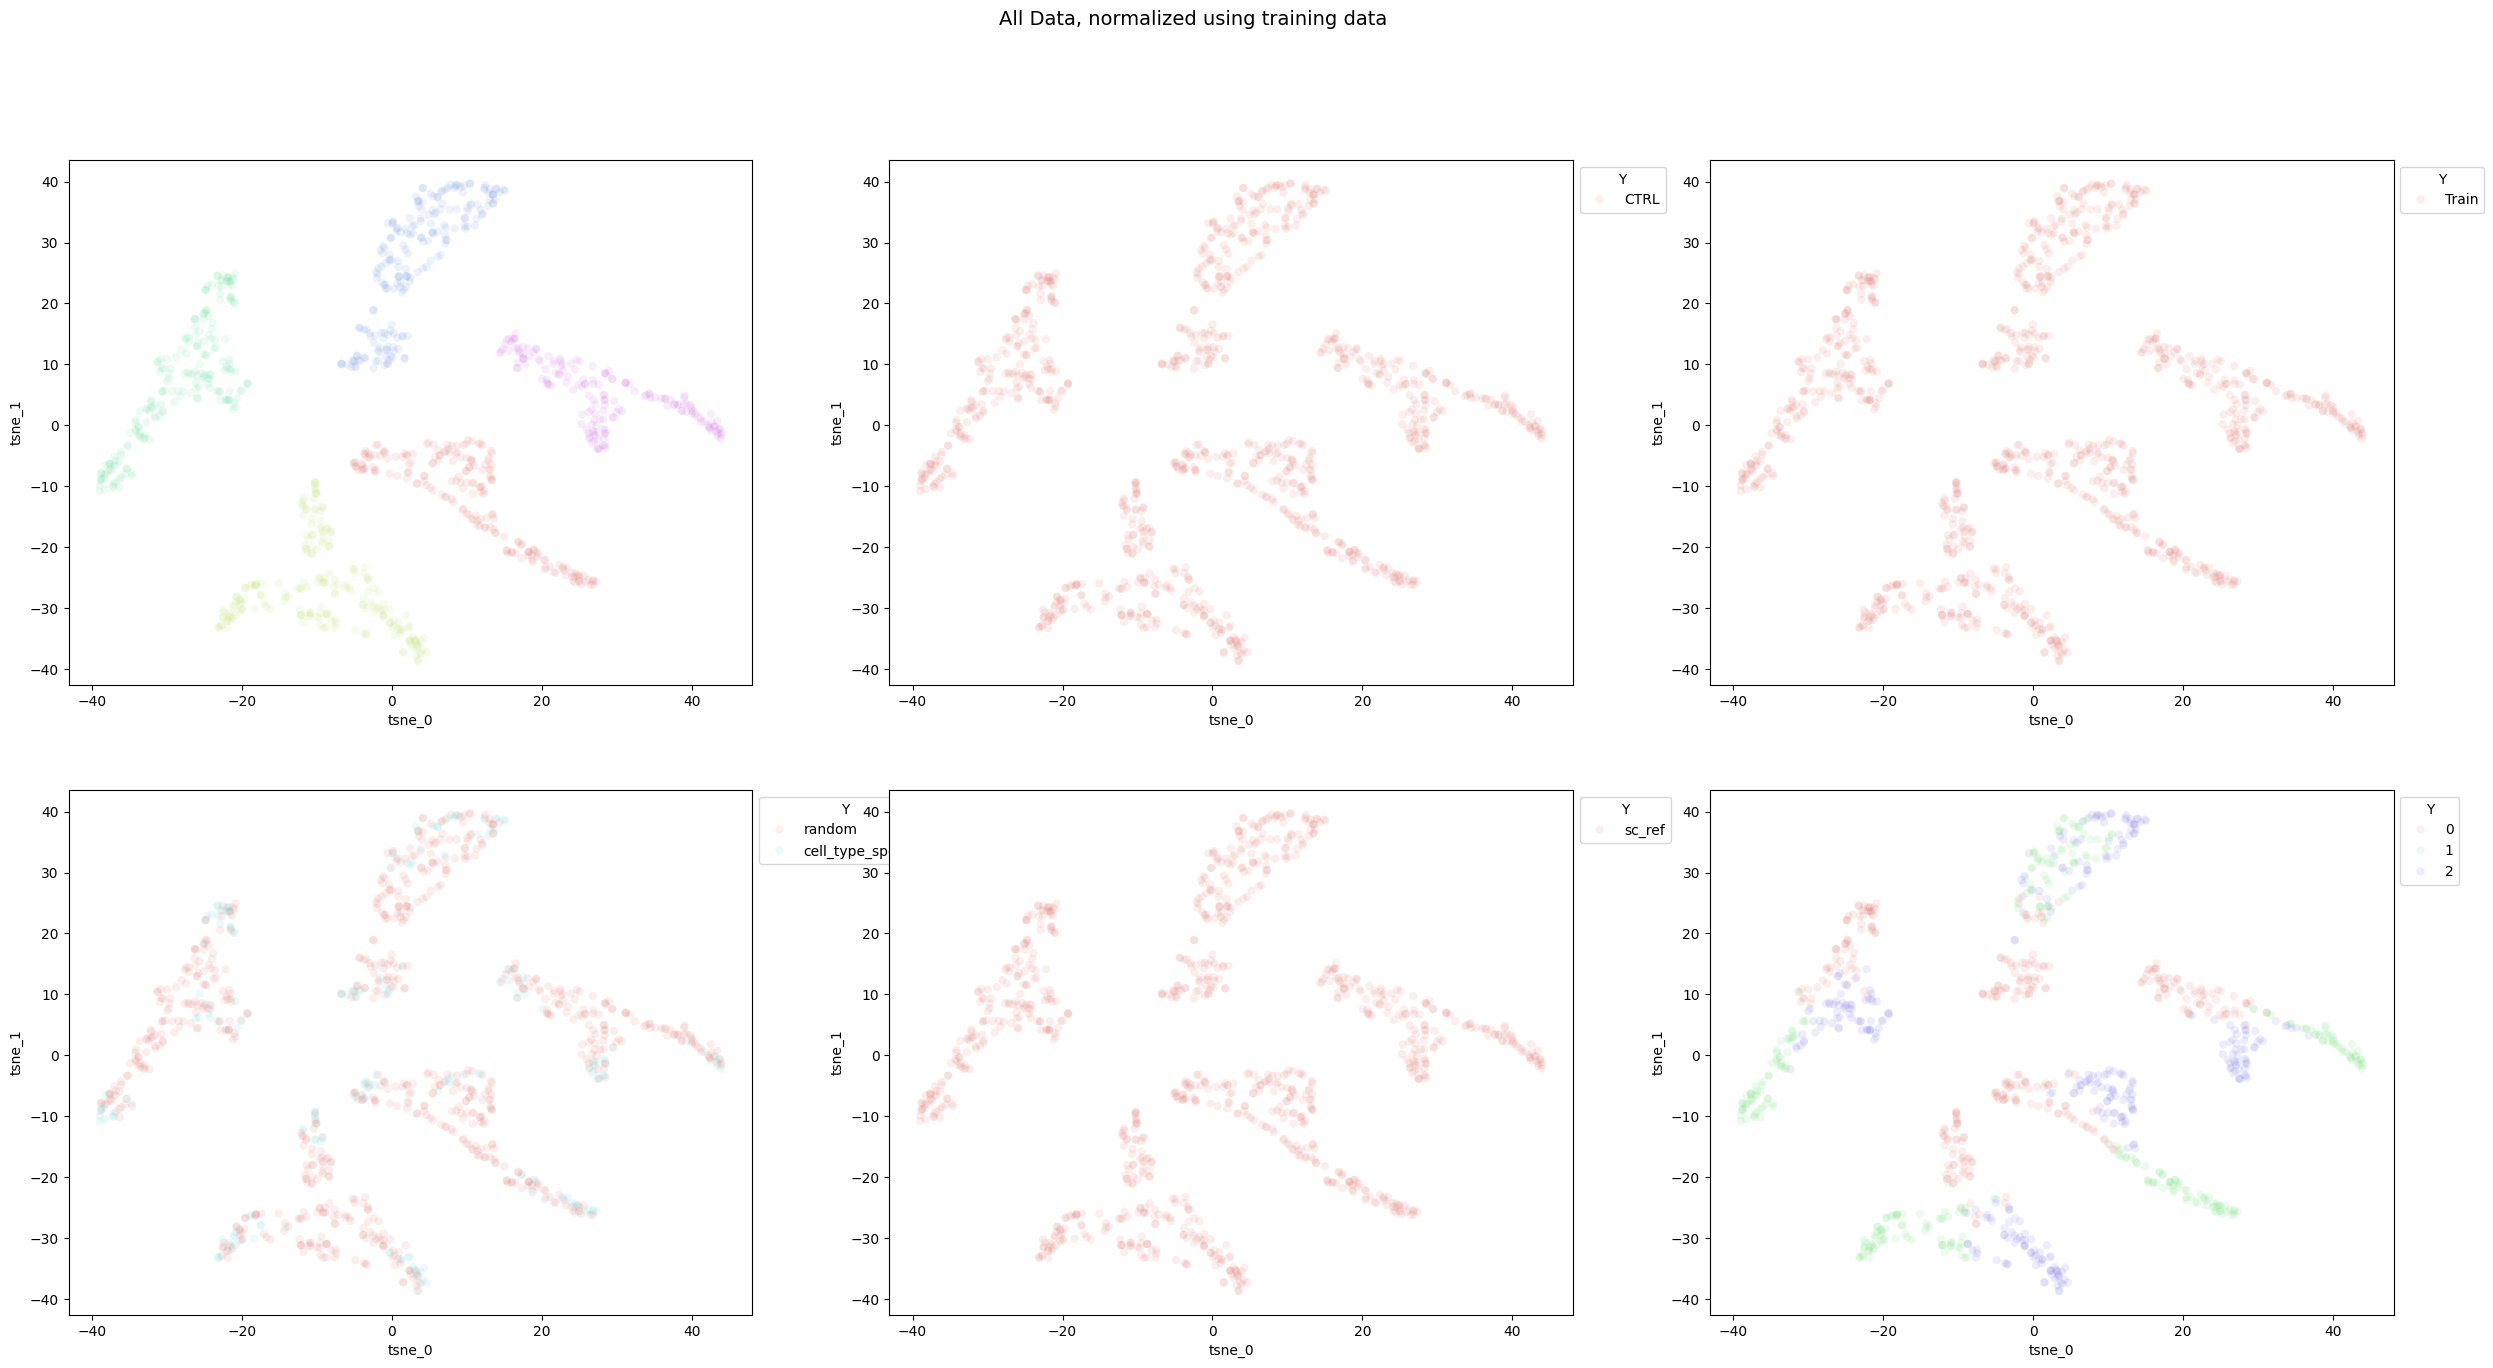

In [10]:
## plot samples
idx_tmp = np.random.choice(range(X_concat.shape[0]), 1000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_concat.iloc[idx_tmp])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_concat.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


In [11]:
Y_concat

,immune,tumor,stromal
0,0.500000,0.425000,0.075000
0,0.260000,0.045000,0.695000
0,0.170000,0.425000,0.405000
0,0.025000,0.730000,0.245000
0,0.105000,0.085000,0.810000
...,...,...,...
0,0.006029,0.010921,0.983050
0,0.011116,0.013224,0.975659
0,0.005960,0.019983,0.974057
0,0.031106,0.016910,0.951984


In [12]:
X_concat

gene_ids,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,AL645608.5,AL645608.1,SAMD11,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1
0,0.0,2.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,15.0,...,0.0,3.0,1.0,8.0,0.0,0.0,9.0,0.0,0.0,2.0
0,0.0,5.0,0.0,3.0,2.0,0.0,0.0,0.0,2.0,12.0,...,0.0,1.0,0.0,9.0,2.0,0.0,5.0,1.0,0.0,2.0
0,1.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,16.0,...,0.0,5.0,3.0,19.0,1.0,1.0,5.0,0.0,0.0,3.0
0,0.0,9.0,0.0,9.0,11.0,0.0,3.0,0.0,3.0,29.0,...,1.0,7.0,4.0,20.0,1.0,0.0,8.0,0.0,0.0,2.0
0,0.0,5.0,2.0,4.0,2.0,0.0,1.0,0.0,0.0,13.0,...,0.0,2.0,5.0,15.0,0.0,0.0,7.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,6.0,2.0,4.0,0.0,0.0,0.0,2.0,1.0,28.0,...,4.0,8.0,11.0,6.0,5.0,0.0,0.0,0.0,0.0,6.0
0,0.0,2.0,1.0,4.0,7.0,0.0,0.0,1.0,1.0,30.0,...,2.0,10.0,8.0,9.0,4.0,0.0,0.0,0.0,0.0,7.0
0,0.0,4.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,21.0,...,1.0,7.0,7.0,5.0,4.0,0.0,0.0,0.0,0.0,12.0
0,0.0,5.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,30.0,...,1.0,7.0,7.0,4.0,3.0,0.0,0.0,0.0,1.0,14.0


In [13]:
pd.DataFrame(gene_df)

,gene_ids
gene_ids,
AL627309.1,AL627309.1
AL669831.5,AL669831.5
FAM87B,FAM87B
LINC00115,LINC00115
FAM41C,FAM41C
...,...
AC023491.2,AC023491.2
AC004556.1,AC004556.1
AC233755.2,AC233755.2


In [14]:
result_ad_file_tsv = f"{sc_aug_data_path}/{exp_id}.tsv"
X_concat.to_csv(result_ad_file_tsv, sep="\t")

In [15]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/2_format_write_pseudobulk/../../data/single_cell/GSE154600_pseudobulks//all-granular.h5ad'

In [16]:

# make anndata

# write out anndata for R to run consensusOV

meta_concat.index = range(0,meta_concat.shape[0])
Y_concat.index = meta_concat.index
X_concat.index = meta_concat.index
X_concat.columns

full_meta = pd.concat([meta_concat, Y_concat], axis=1)

adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))

adata.write(result_ad_file)

adata

/tmp/ipykernel_2366252/4003203352.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 6500 × 24520
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'immune', 'tumor', 'stromal'
    var: 'gene_ids'